In [1]:
# conda install tensorflow-gpu==2.1.0 matplotlib
# pip install sciann
# sciann version: 0.6.3.1
import pathlib
import numpy as np
import time
import sciann as sn
from sciann_datagenerator import DataGeneratorXY
from sciann.utils.math import diff
import tensorflow.keras.callbacks as callbacks
from scipy.special import hankel1
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import matplotlib.gridspec as gridspec

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [2]:
def data_tmp(start=-2, end=8, num=50000, amp=1.0, sz=0.0, sr=0.0):
    dg = DataGeneratorXY(
        X=[start, end],
        Y=[start, end],
        targets=["domain"],
        num_sample=num,
    )
    dg.plot_sample_batch(batch_size=256)
    xx = np.squeeze(dg.input_data[0])
    yy = np.squeeze(dg.input_data[1])
    rr = np.sqrt((xx-sr)**2 + (yy-sz)**2)

    # Green(x,y) = Hankel_0^1(k * r)
    freq = 50.0
    Pi = 3.141592653

    omega = 2 * Pi * freq
    m0 = 1/1500.0
    m1 = 1/1450.0
    k0 = omega * m0
    k1 = omega * m1
    u0_real = np.real(amp * hankel1(0, k1*rr))
    u0_imag = np.imag(amp * hankel1(0, k1*rr))

    G0_real = np.real(amp * hankel1(0, k0*rr))
    G0_imag = np.imag(amp * hankel1(0, k0*rr))

    # # complex valued part is phase shifted by 90°
    # k_out = k0 * np.ones(u0_real.shape)

    dp_real = u0_real - G0_real
    dp_imag = u0_imag - G0_imag
    return xx, yy, dp_real, dp_imag, omega, G0_real, G0_imag, m0, m1

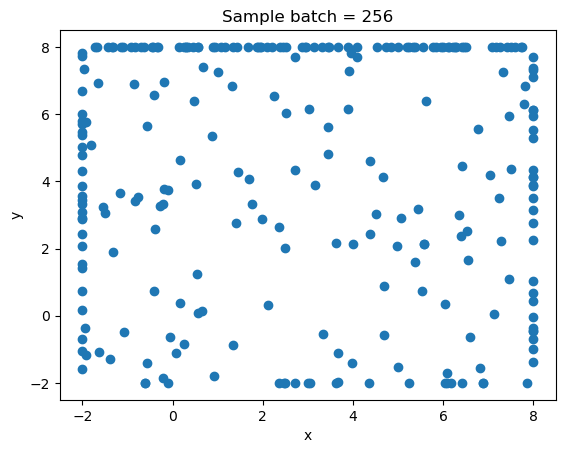

In [3]:
if __name__ == "__main__":
    # prepare data
    r_data, z_data, p_real_data, p_imag_data, omega, G_real_data, G_imag_data, m0, m1 = data_tmp(num=10000)
    
    noise = 0.001        
    pr_Noise_train = p_real_data + noise*np.std(p_real_data + G_real_data)*np.random.randn(1)
    pi_Noise_train = p_imag_data + noise*np.std(p_imag_data + G_imag_data)*np.random.randn(1)  
    isTrain = False
    AddNoise = False
#     isTrain = False
    k0_data = omega * m0 * np.ones(r_data.shape)
    k1_data = omega * m1 * np.ones(r_data.shape)

    # Variable and Fields
    r = sn.Variable("r", dtype='float64')
    z = sn.Variable("z", dtype='float64')
    k0 = sn.Variable("k0", dtype='float64')
    k1 = sn.Variable("k1", dtype='float64')
    G_real = sn.Variable("G_real", dtype='float64')
    G_imag = sn.Variable("G_imag", dtype='float64')

    p_real = sn.Functional("p_real", [r, z, k0, k1, G_real], 4*[20], "sin")
    p_imag = sn.Functional("p_imag", [r, z, k0, k1, G_imag], 4*[20], "sin")
    
    lambda1 = sn.Parameter(np.random.normal(loc=1.0), inputs=[r,z,k0,k1], name="lambda1")
    lambda2 = sn.Parameter(np.random.normal(loc=1.0), inputs=[r,z,k0,k1], name="lambda2")
    # pde ($\Delta p + k^2 \cdot p = 0$) split into real- and complex-valued part
    laplace_Re_dp = lambda1*diff(p_real, r, order=2) + lambda2*diff(p_real, z, order=2)
    laplace_Im_dp = lambda1*diff(p_imag, r, order=2) + lambda2*diff(p_imag, z, order=2)

    L1 = laplace_Re_dp+k1**2 * p_real + (k1**2 - k0**2)*G_real
    L2 = laplace_Im_dp+k1**2 * p_imag + (k1**2 - k0**2)*G_imag
    c1 = sn.Data(p_real)
    c2 = sn.Data(p_imag)

    # model and input
    input = [r, z, k0, k1, G_real, G_imag]
    input_value = [r_data, z_data, k0_data, k1_data, G_real_data, G_imag_data]
    target = [sn.PDE(L1), sn.PDE(L2), c1, c2]
    target_value = ['zeros', 'zeros', p_real_data, p_imag_data]
    model = sn.SciModel(
        input,
        target,
#         optimizer='scipy-l-BFGS-B')
        load_weights_from='model/2D1_dp_PDE_WEIGHT.hdf5')
#         optimizer='scipy-l-BFGS-B')

    # callbacks
    current_path = os.path.abspath('')
    checkpoint_filepath = str(os.path.join(current_path,'callbacks/N2Green/N2Green_dp.ckpt'))
    save_path1 = str(os.path.join(current_path,'model/2D1_dp_PDE_WEIGHT.hdf5'))
    save_path2 = str(os.path.join(current_path,'model/2D1_dp_Noi_WEIGHT.hdf5'))
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True
    )
    if isTrain:
        if AddNoise:
            t = time.time()
            history1 = model.train(
                input_value,
                target_value,
                epochs=1500,
                batch_size=400,
                adaptive_weights={"method": "NTK", "freq": 100},
                # callbacks=[model_checkpoint_callback],
                shuffle=True,
                learning_rate=0.005,
                reduce_lr_after=100,
                stop_loss_value=1e-8,
                verbose=0
            )
            t = time.time() - t
            #
            model.save_weights(save_path1)
            fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=80)
            loss1 = history1.history['p_real_loss']
            loss2 = history1.history['p_imag_loss']
            time_step = np.linspace(0, t, len(history1.history["p_real_loss"]))
            print(time_step.shape)
            plt.plot(history1.history['p_real_loss'] / loss1[0], 'r', label='$p_{real}$-loss')
            plt.plot(history1.history['p_imag_loss'] / loss2[0], 'b', label='$p_{imag}$-loss')
            plt.yscale('log')
            plt.xlabel('epoch')
            plt.ylabel('Mean-Squared-Error')
            plt.title('Loss')
            plt.legend()
            plt.show()
            print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))
            # add Noise
            target_value = ['zeros', 'zeros', pr_Noise_train, pi_Noise_train]
            model_noise = sn.SciModel(input, target,load_weights_from='model/2D1_dp_Noi_WEIGHT.hdf5')
            t = time.time()
            history2 = model_noise.train(
                input_value,
                target_value,
                epochs=1500,
                batch_size=400,
                adaptive_weights={"method": "NTK", "freq": 100},
                # callbacks=[model_checkpoint_callback],
                shuffle=True,
                learning_rate=0.005,
                reduce_lr_after=100,
                stop_loss_value=1e-8,
                verbose=0
            )
            t = time.time() - t
            #
            model_noise.save_weights(save_path2)
            fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=80)
            loss1 = history2.history['p_real_loss']
            loss2 = history2.history['p_imag_loss']
            time_step = np.linspace(0, t, len(history2.history["p_real_loss"]))
            print(time_step.shape)
            plt.plot(history2.history['p_real_loss'] / loss1[0], 'r', label='$p_{real}$-loss')
            plt.plot(history2.history['p_imag_loss'] / loss2[0], 'b', label='$p_{imag}$-loss')
            plt.yscale('log')
            plt.xlabel('epoch')
            plt.ylabel('Mean-Squared-Error')
            plt.title('Loss(Noise)')
            plt.legend()
            plt.show()
            print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))
        else:
            t = time.time()
            history1 = model.train(
                input_value,
                target_value,
                epochs=1500,
                batch_size=400,
                adaptive_weights={"method": "NTK", "freq": 100},
                # callbacks=[model_checkpoint_callback],
                shuffle=True,
                learning_rate=0.005,
                reduce_lr_after=100,
                stop_loss_value=1e-8,
                verbose=0
            )
            t = time.time() - t
            #
            model.save_weights(save_path1)
            fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=80)
            loss1 = history1.history['p_real_loss']
            loss2 = history1.history['p_imag_loss']
            time_step = np.linspace(0, t, len(history1.history["p_real_loss"]))
            print(time_step.shape)
            plt.plot(history1.history['p_real_loss'] / loss1[0], 'r', label='$p_{real}$-loss')
            plt.plot(history1.history['p_imag_loss'] / loss2[0], 'b', label='$p_{imag}$-loss')
            plt.yscale('log')
            plt.xlabel('epoch')
            plt.ylabel('Mean-Squared-Error')
            plt.title('Loss')
            plt.legend()
            plt.show()   
    else:
        if AddNoise:
            model.load_weights(save_path1)
            
            # add Noise
            target_value = ['zeros', 'zeros', pr_Noise_train, pi_Noise_train]
            model_noise = sn.SciModel(input, target)
            t = time.time()
            history2 = model_noise.train(
                input_value,
                target_value,
                epochs=1500,
                batch_size=400,
                adaptive_weights={"method": "NTK", "freq": 100},
                # callbacks=[model_checkpoint_callback],
                shuffle=True,
                learning_rate=0.005,
                reduce_lr_after=100,
                stop_loss_value=1e-8,
                verbose=0
            )
            t = time.time() - t
            #
            model_noise.save_weights(save_path2)
            fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=80)
            loss1 = history2.history['p_real_loss']
            loss2 = history2.history['p_imag_loss']
            time_step = np.linspace(0, t, len(history2.history["p_real_loss"]))
            print(time_step.shape)
            plt.plot(history2.history['p_real_loss'] / loss1[0], 'r', label='$p_{real}$-loss')
            plt.plot(history2.history['p_imag_loss'] / loss2[0], 'b', label='$p_{imag}$-loss')
            plt.yscale('log')
            plt.xlabel('epoch')
            plt.ylabel('Mean-Squared-Error')
            plt.title('Loss(Noise)')
            plt.legend()
            plt.show()
        else:
            model.load_weights(save_path1)
            model_noise = sn.SciModel(input, target)
            model_noise.load_weights(save_path2)

In [4]:
    # predictions
    N = 1000
    x_max = 8
    y_max = 8
    x_min = -2
    y_min = -2
    xx = np.linspace(x_min, x_max, N)
    yy = np.linspace(y_min, y_max, N)
    sx = 0
    sy = 0

    x_test, y_test = np.meshgrid(xx, yy)
    x_eval = x_test.flatten()
    y_eval = y_test.flatten()
    r_eval = np.sqrt((x_eval-sx)**2 + (y_eval-sy)**2)
    k0 = k0_data[0]
    k1 = k1_data[0]
    k0_test = k0 * np.ones(x_eval.shape)
    k1_test = k1 * np.ones(x_eval.shape)
    G_real_test = np.real(hankel1(0, k0*r_eval))
    G_imag_test = np.imag(hankel1(0, k0*r_eval))
    
    input_plot = [x_eval, y_eval, k0_test, k1_test, G_real_test, G_imag_test]
    
    p_real_pred = p_real.eval(model, input_plot)
    p_imag_pred = p_imag.eval(model, input_plot)
    # parameters
#     lambda1_value = lambda1.eval(model, input_plot)
#     print(lambda1.value)
#     lambda2_value = lambda2.eval(model, input_plot)
#     lambda1_Noise = lambda1.eval(model_noise, input_plot)
#     print(lambda2.value)
#     lambda2_Noise = lambda2.eval(model_noise, input_plot)
    
    
    p_real_pred = (p_real_pred + G_real_test).reshape(x_test.shape)
    p_imag_pred = (p_imag_pred + G_imag_test).reshape(x_test.shape)
    k1_test = k1_test.reshape(x_test.shape)

    # exact solution
    p_real_exsol = np.real(hankel1(0, k1_test * np.sqrt((x_test-sx) ** 2 + (y_test-sy) ** 2)))
    p_imag_exsol = np.imag(hankel1(0, k1_test * np.sqrt((x_test-sx) ** 2 + (y_test-sy) ** 2)))

    # pre2tl
    pr_exsol = (p_real_exsol / np.real(hankel1(0, k1_test))) ** 2
    pi_exsol = (p_imag_exsol / np.imag(hankel1(0, k1_test))) ** 2
    tl_exsol = -20 * np.log10(np.sqrt(pr_exsol + pi_exsol))

    pr_pred = (p_real_pred / np.real(hankel1(0, k1_test))) ** 2
    pi_pred = (p_imag_pred / np.imag(hankel1(0, k1_test))) ** 2
    tl_pred = -20 * np.log10(np.sqrt(pr_pred + pi_pred))

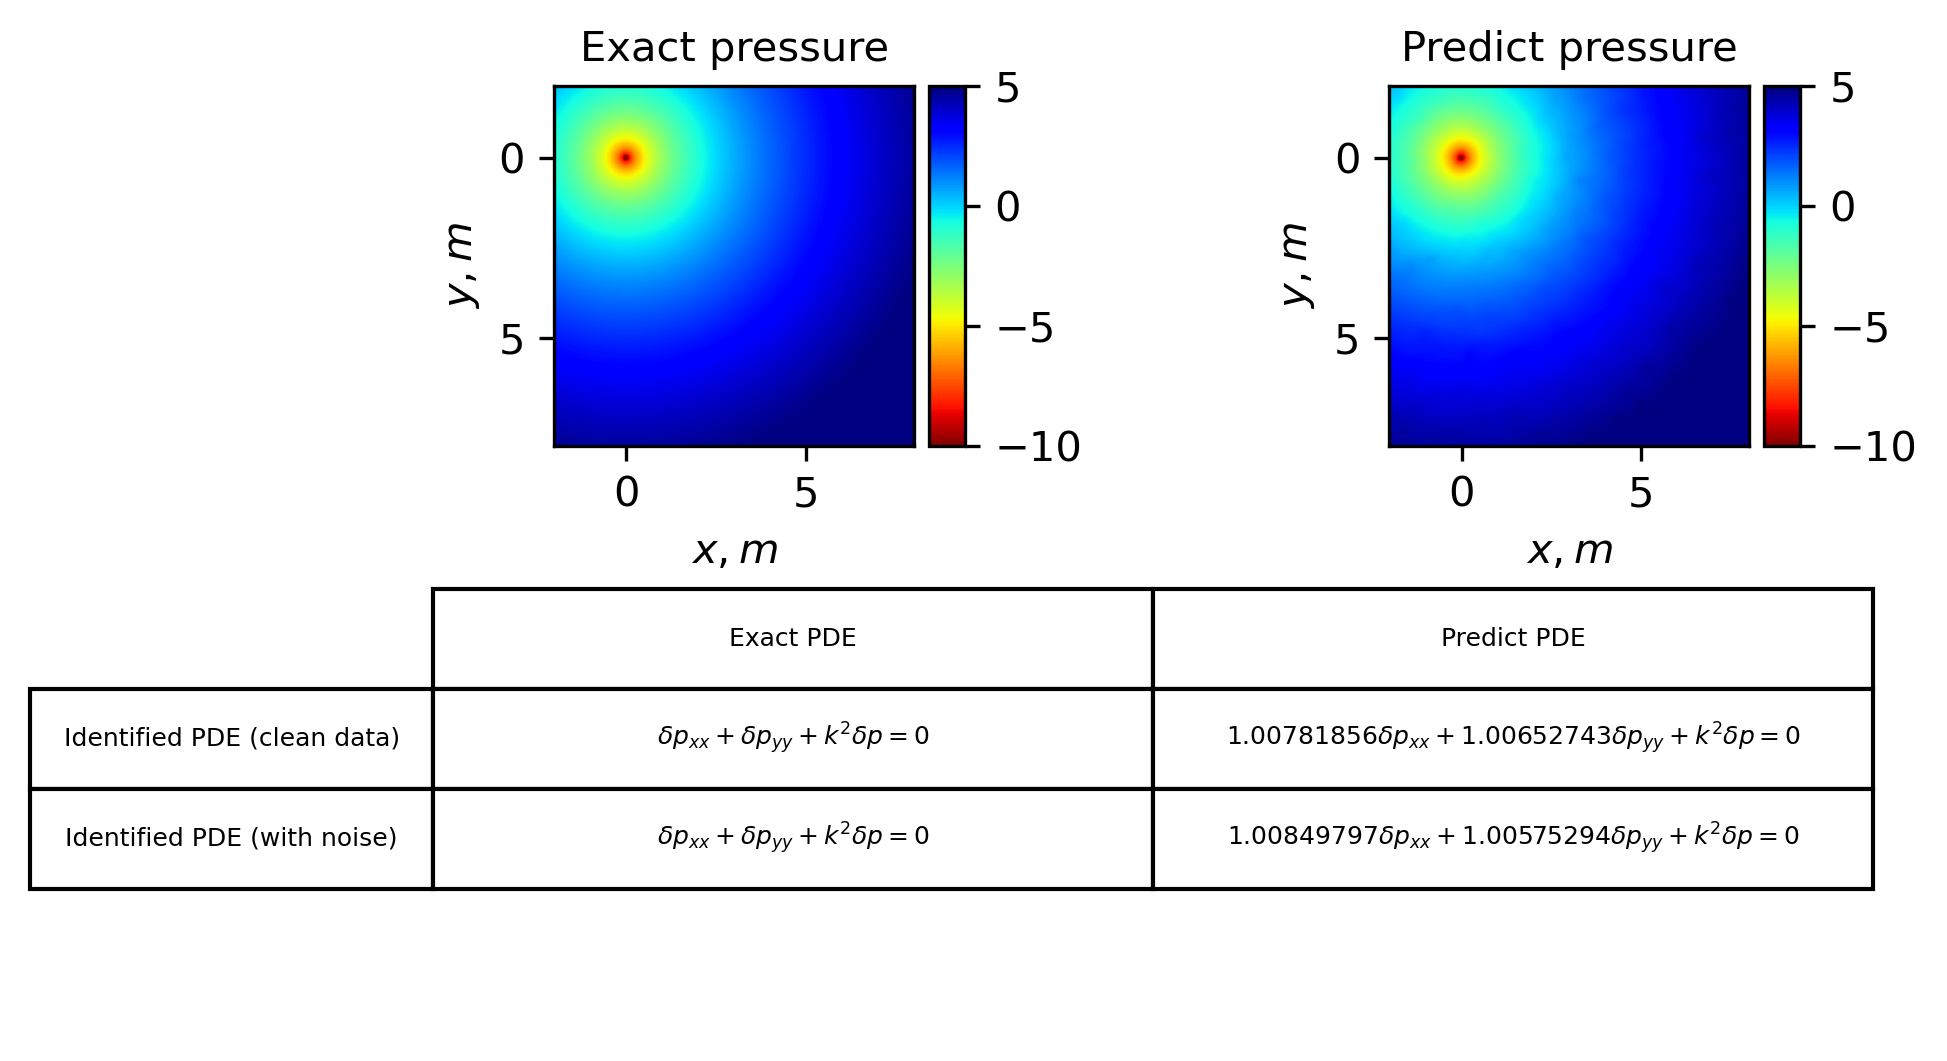

In [23]:
    fig = plt.figure(figsize=(8, 3), dpi=300)
    ax = plt.subplot(111)
    ax.axis('off')
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=0.9, bottom=1-1/2, left=0.32, right=0.9, wspace=0.5)
    ## Row 1
    # exact: Transmission Loss
    ax = plt.subplot(gs1[:, 0])
    ax.invert_yaxis()
    h1 = ax.pcolormesh(xx, yy, tl_exsol, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
    divider = make_axes_locatable(ax)
    cax2 = divider.append_axes("right", size="10%", pad=0.05)
    fig.colorbar(h1, cax=cax2)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Exact pressure', fontsize = 10)
    
    # eval: Transmission Loss
    ax = plt.subplot(gs1[:, 1])
    ax.invert_yaxis()
    h3 = ax.pcolormesh(xx, yy, tl_pred, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
    divider = make_axes_locatable(ax)
    cax4 = divider.append_axes("right", size="10%", pad=0.05)
    fig.colorbar(h3, cax=cax4)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Predict pressure', fontsize = 10)
        
    ## Row2: 
    # Table
    gs2 = gridspec.GridSpec(1, 2)
    gs2.update(top=1-1/2, bottom=-0.15, left=0.3, right=0.9, wspace=0.5)
    ax = plt.subplot(gs2[:, :])
    ax.axis('off')
    col = ['Exact PDE', 'Predict PDE']
    row = ['Identified PDE (clean data)', 'Identified PDE (with noise)']
    vals = [['$\delta p_{xx}+\delta p_{yy}+k^2 \delta p=0$', str(1.00781856)+'$\delta p_{xx}+$'+str(1.00652743)+'$\delta p_{yy}+k^2\delta p=0$'],
           ['$\delta p_{xx}+\delta p_{yy}+k^2 \delta p=0$', str(1.00849797)+'$\delta p_{xx}+$'+str(1.00575294)+'$\delta p_{yy}+k^2\delta p=0$']]
    tab = plt.table(cellText=vals,
                   colLabels=col,
                   rowLabels=row,
                   loc='center',
                   cellLoc='center',
                   rowLoc='center')
    tab.scale(1,2)
#     plt.savefig('figures/fig3-1.png',dpi=300)
    plt.show()
    

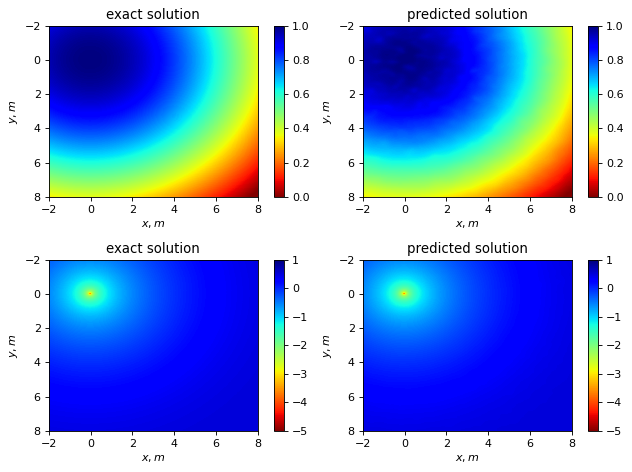

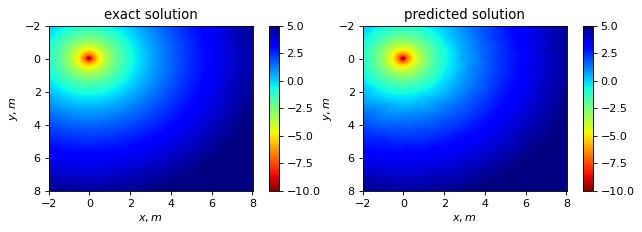

In [6]:
    # pressure
    fig = plt.figure(1, figsize=(8, 6), dpi=80)
    ax = plt.subplot(2, 2, 1)
    ax.invert_yaxis()
    h0 = ax.pcolormesh(xx, yy, p_real_exsol, cmap='jet_r', shading='auto', vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(h0, cax=cax1)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('exact solution')

    ax = plt.subplot(2, 2, 2)
    ax.invert_yaxis()
    h2 = ax.pcolormesh(xx, yy, p_real_pred, cmap='jet_r', shading='auto', vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax3 = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(h2, cax=cax3)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('predicted solution')
    plt.tight_layout()
    
    ax = plt.subplot(2, 2, 3)
    ax.invert_yaxis()
    h1 = ax.pcolormesh(xx, yy, p_imag_exsol, cmap='jet_r', shading='auto', vmin=-5, vmax=1)
    divider = make_axes_locatable(ax)
    cax2 = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(h1, cax=cax2)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('exact solution')

    ax = plt.subplot(2, 2, 4)
    ax.invert_yaxis()
    h3 = ax.pcolormesh(xx, yy, p_imag_pred, cmap='jet_r', shading='auto', vmin=-5, vmax=1)
    divider = make_axes_locatable(ax)
    cax4 = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(h3, cax=cax4)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('predicted solution')
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(3, figsize=(8, 3), dpi=80)
    ax = plt.subplot(1, 2, 1)
    ax.invert_yaxis()
    h1 = ax.pcolormesh(xx, yy, tl_exsol, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
    divider = make_axes_locatable(ax)
    cax2 = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(h1, cax=cax2)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('exact solution')

    ax = plt.subplot(1, 2, 2)
    ax.invert_yaxis()
    h3 = ax.pcolormesh(xx, yy, tl_pred, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
    divider = make_axes_locatable(ax)
    cax4 = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(h3, cax=cax4)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('predicted solution')
    plt.tight_layout()
    plt.show()

In [7]:
    def plot_line(ny, ax):
            zy = ny * dy
            print(ny)
            fig = plt.figure(ax, figsize=(10, 3), dpi=80)
            plt.suptitle('Receive Depth='+str(zy+y_min)+'m')
            ax = plt.subplot(1, 3, 1)
            ax.invert_yaxis()
            h6 = ax.plot(xx, p_real_exsol[ny, :], 'r', linewidth=1.5, label='exact')
            h7 = ax.plot(xx, p_real_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
            ax.set_xlabel('$x, m$')
            ax.set_ylabel('$Amp$')
            ax.set_title('Real Pressure')
            plt.legend()

            ax = plt.subplot(1, 3, 2)
            ax.invert_yaxis()
            h8 = ax.plot(xx, p_imag_exsol[ny, :], 'r', linewidth=1.5, label='exact')
            h9 = ax.plot(xx, p_imag_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
            ax.set_xlabel('$x, m$')
            ax.set_ylabel('$Amp$')
            ax.set_title('Image Pressure')
            plt.legend()
            plt.tight_layout()

            ax = plt.subplot(1, 3, 3)
            ax.invert_yaxis()
            h10 = ax.plot(xx, tl_exsol[ny, :], 'r', linewidth=1.5, label='exact')
            h11 = ax.plot(xx, tl_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
            ax.set_xlabel('$x, m$')
            ax.set_ylabel('$dB$')
            ax.set_title('TL')
            plt.legend()

            plt.tight_layout()
            plt.show()

50


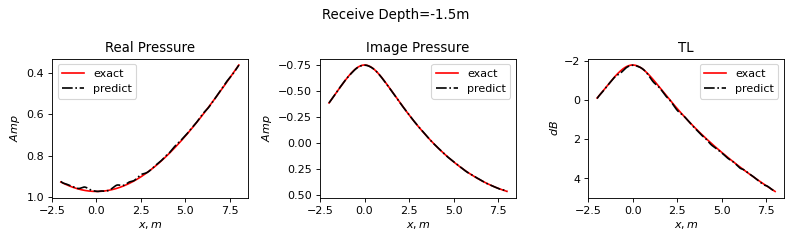

100


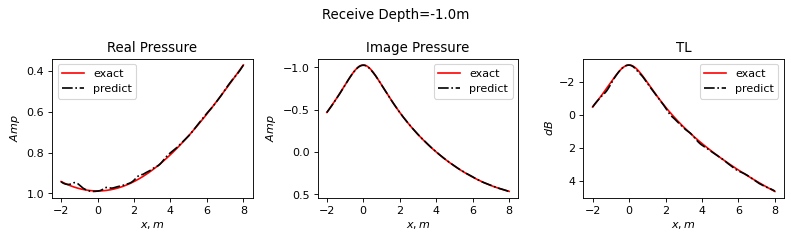

200


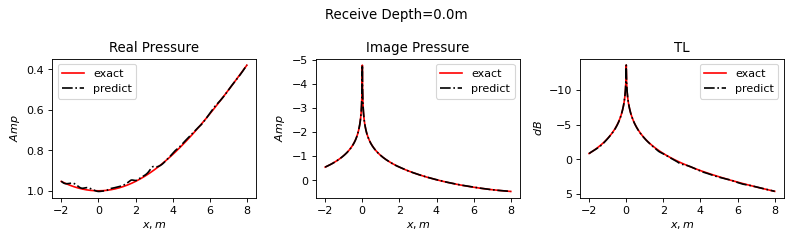

450


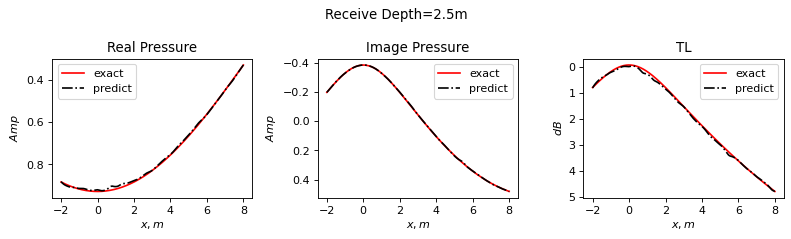

In [8]:
    dx = (x_max - x_min) / N
    dy = (y_max - y_min) / N
#     zy = 3
#     ny = int(zy / dy)
    ax = 5
    
    plot_line(int((-1.5 - y_min)/dy), ax)
    plot_line(int((-1 - y_min)/dy), ax)
    plot_line(int((+0 - y_min)/dy), ax)
    plot_line(int((+2.5 - y_min)/dy), ax)